<a href="https://colab.research.google.com/github/eunicean/Proyecto-DeepLearning/blob/main/CNN/HIRAGANA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("farukece/handwritten-japanese-hiragana-characters")

print("Path to dataset files:", dataset_path)

100%|██████████| 31.7M/31.7M [00:02<00:00, 12.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/farukece/handwritten-japanese-hiragana-characters/versions/1


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from collections import Counter


In [3]:
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')

    # Solo mostrar los primeros niveles para no saturar
    if level < 2:
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Mostrar solo los primeros 5 archivos
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... y {len(files) - 5} archivos más')

    if level >= 3:
        break

1/
  hiragana/
    wo/
    ka/
    mi/
    so/
    wa/
    mu/
    ni/
    aa/
    no/
    chi/
    nn/
    ha/
    nu/
    ke/
    re/
    shi/
    na/
    fu/
    ne/
    ho/
    ku/
    uu/
    ro/
    hi/
    su/
    me/
    to/
    he/
    ma/
    se/
    sa/
    ya/
    tsu/
    yo/
    ee/
    ri/
    ru/
    ra/
    yu/
    oo/
    ii/
    mo/
    ko/
    ta/
    te/
    ki/


In [4]:
# Analizar cada carpeta de hiragana
hiragana_path = os.path.join(dataset_path, "hiragana")

# Diccionario para almacenar la información
hiragana_data = {}

print("Conteo de imágenes por carácter Hiragana:")

for character_folder in sorted(os.listdir(hiragana_path)):
    folder_path = os.path.join(hiragana_path, character_folder)

    if os.path.isdir(folder_path):
        # Contar archivos de imagen
        image_files = [f for f in os.listdir(folder_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        hiragana_data[character_folder] = {
            'num_imagenes': len(image_files),
            'ruta': folder_path,
            'archivos': image_files
        }

        print(f"{character_folder:8s} tiene {len(image_files):3d} imágenes")

# Crear DataFrame para análisis
df_hiragana = pd.DataFrame.from_dict(hiragana_data, orient='index')
df_hiragana = df_hiragana.reset_index().rename(columns={'index': 'caracter'})

print("\n")
print(f"RESUMEN:")
print(f"Total de caracteres: {len(df_hiragana)}")
print(f"Total de imágenes: {df_hiragana['num_imagenes'].sum()}")
print(f"\nEstadísticas:")
print(f"  - Mínimo: {df_hiragana['num_imagenes'].min()} imágenes")
print(f"  - Máximo: {df_hiragana['num_imagenes'].max()} imágenes")
print(f"  - Promedio: {df_hiragana['num_imagenes'].mean():.2f} imágenes")
print(f"  - Mediana: {df_hiragana['num_imagenes'].median():.0f} imágenes")

# Verificar si todas las clases tienen 100 imágenes
clases_con_100 = df_hiragana[df_hiragana['num_imagenes'] == 100]
print(f"\nClases con exactamente 100 imágenes: {len(clases_con_100)}/{len(df_hiragana)}")

if len(df_hiragana) != len(clases_con_100):
    print("\nClases con cantidad diferente a 100:")
    clases_diferentes = df_hiragana[df_hiragana['num_imagenes'] != 100]
    for _, row in clases_diferentes.iterrows():
        print(f"  - {row['caracter']}: {row['num_imagenes']} imágenes")

Conteo de imágenes por carácter Hiragana:
aa       tiene 100 imágenes
chi      tiene 100 imágenes
ee       tiene 100 imágenes
fu       tiene 100 imágenes
ha       tiene 100 imágenes
he       tiene 100 imágenes
hi       tiene 100 imágenes
ho       tiene 100 imágenes
ii       tiene 100 imágenes
ka       tiene 100 imágenes
ke       tiene 100 imágenes
ki       tiene 100 imágenes
ko       tiene 100 imágenes
ku       tiene 100 imágenes
ma       tiene 100 imágenes
me       tiene 100 imágenes
mi       tiene 100 imágenes
mo       tiene 100 imágenes
mu       tiene 100 imágenes
na       tiene 100 imágenes
ne       tiene 100 imágenes
ni       tiene 100 imágenes
nn       tiene 100 imágenes
no       tiene 100 imágenes
nu       tiene 100 imágenes
oo       tiene 100 imágenes
ra       tiene 100 imágenes
re       tiene 100 imágenes
ri       tiene 100 imágenes
ro       tiene 100 imágenes
ru       tiene 100 imágenes
sa       tiene 100 imágenes
se       tiene 100 imágenes
shi      tiene 100 imágenes
so    

# División de datos en entrenamiento y prueba

In [5]:
from sklearn.model_selection import train_test_split
import shutil

# Configuración de la división
TRAIN_RATIO = 0.70  # 70% entrenamiento
VAL_RATIO = 0.15    # 15% validación
TEST_RATIO = 0.15   # 15% test

print(" Configuración de división del dataset:")
print("\n")
print(f"Train: {TRAIN_RATIO*100:.0f}% ({int(100*TRAIN_RATIO)} imágenes por clase)")
print(f"Validation: {VAL_RATIO*100:.0f}% ({int(100*VAL_RATIO)} imágenes por clase)")
print(f"Test: {TEST_RATIO*100:.0f}% ({int(100*TEST_RATIO)} imágenes por clase)")
print(f"\nTotal por clase: 100 imágenes")
print("\n")

# Crear estructura de directorios
base_output_path = "/content/hiragana_dataset"
splits = ['train', 'val', 'test']

# Crear carpetas
for split in splits:
    split_path = os.path.join(base_output_path, split)
    os.makedirs(split_path, exist_ok=True)
    print(f" Creado: {split_path}")

print("\nProcesando división del dataset...")

# Realizar la división estratificada para cada clase
np.random.seed(42)  # Para reproducibilidad

stats = {
    'train': 0,
    'val': 0,
    'test': 0
}

for character in sorted(df_hiragana['caracter']):
    # Obtener la ruta de la carpeta del carácter
    source_folder = os.path.join(hiragana_path, character)

    # Obtener lista de imágenes
    images = [f for f in os.listdir(source_folder)
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Mezclar aleatoriamente
    np.random.shuffle(images)

    # Calcular índices de división
    n_images = len(images)
    train_end = int(n_images * TRAIN_RATIO)
    val_end = train_end + int(n_images * VAL_RATIO)

    # Dividir las imágenes
    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    # Crear carpetas para cada split
    for split in splits:
        split_char_path = os.path.join(base_output_path, split, character)
        os.makedirs(split_char_path, exist_ok=True)

    # Copiar imágenes a sus respectivas carpetas
    # TRAIN
    for img in train_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'train', character, img)
        shutil.copy2(src, dst)
        stats['train'] += 1

    # VALIDATION
    for img in val_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'val', character, img)
        shutil.copy2(src, dst)
        stats['val'] += 1

    # TEST
    for img in test_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(base_output_path, 'test', character, img)
        shutil.copy2(src, dst)
        stats['test'] += 1

print("\nDivisión completada!")
print("\nResumen de la división:")
print("\n")
print(f"Train:      {stats['train']:4d} imágenes ({stats['train']/4600*100:.1f}%)")
print(f"Validation: {stats['val']:4d} imágenes ({stats['val']/4600*100:.1f}%)")
print(f"Test:       {stats['test']:4d} imágenes ({stats['test']/4600*100:.1f}%)")
print(f"Total:      {sum(stats.values()):4d} imágenes")
print("\n")

 Configuración de división del dataset:


Train: 70% (70 imágenes por clase)
Validation: 15% (15 imágenes por clase)
Test: 15% (15 imágenes por clase)

Total por clase: 100 imágenes


 Creado: /content/hiragana_dataset/train
 Creado: /content/hiragana_dataset/val
 Creado: /content/hiragana_dataset/test

Procesando división del dataset...

División completada!

Resumen de la división:


Train:      3220 imágenes (70.0%)
Validation:  690 imágenes (15.0%)
Test:        690 imágenes (15.0%)
Total:      4600 imágenes




In [6]:
# Verificar la estructura creada
print("\nVerificación de la estructura:")


for split in splits:
    split_path = os.path.join(base_output_path, split)
    num_classes = len(os.listdir(split_path))

    total_images = 0
    for character in os.listdir(split_path):
        char_path = os.path.join(split_path, character)
        if os.path.isdir(char_path):
            num_images = len([f for f in os.listdir(char_path)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            total_images += num_images

    print(f"\n{split.upper()}:")
    print(f"  - Clases: {num_classes}")
    print(f"  - Total imágenes: {total_images}")
    print(f"  - Promedio por clase: {total_images/num_classes:.1f}")


Verificación de la estructura:

TRAIN:
  - Clases: 46
  - Total imágenes: 3220
  - Promedio por clase: 70.0

VAL:
  - Clases: 46
  - Total imágenes: 690
  - Promedio por clase: 15.0

TEST:
  - Clases: 46
  - Total imágenes: 690
  - Promedio por clase: 15.0


In [7]:
print()

for _file in os.scandir("/content/hiragana_dataset/test/aa"):

  if _file.is_file():
    print(_file.path)


from PIL import Image

# Path to your image file
image_path = "/content/hiragana_dataset/test/aa/drawing_20250805_081540.jpg"

try:
    # Open the image
    img = Image.open(image_path)

    # Get the size (width, height)
    width, height = img.size

    print(f"Image width: {width} pixels")
    print(f"Image height: {height} pixels")

except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
except Exception as e:
    print(f"An error occurred: {e}")


/content/hiragana_dataset/test/aa/drawing_20250805_082247.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082200.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081746.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081951.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082042.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081718.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081928.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081853.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082224.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082058.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081914.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_081633.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082338.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082315.jpg
/content/hiragana_dataset/test/aa/drawing_20250805_082116.jpg
Error: Image file not found at /content/hiragana_dataset/test/aa/draw

Análisis de propiedades de imágenes:


Dimensiones encontradas: {(500, 400)}
Modos de color: {'RGB'}
Total analizado: 10 imágenes


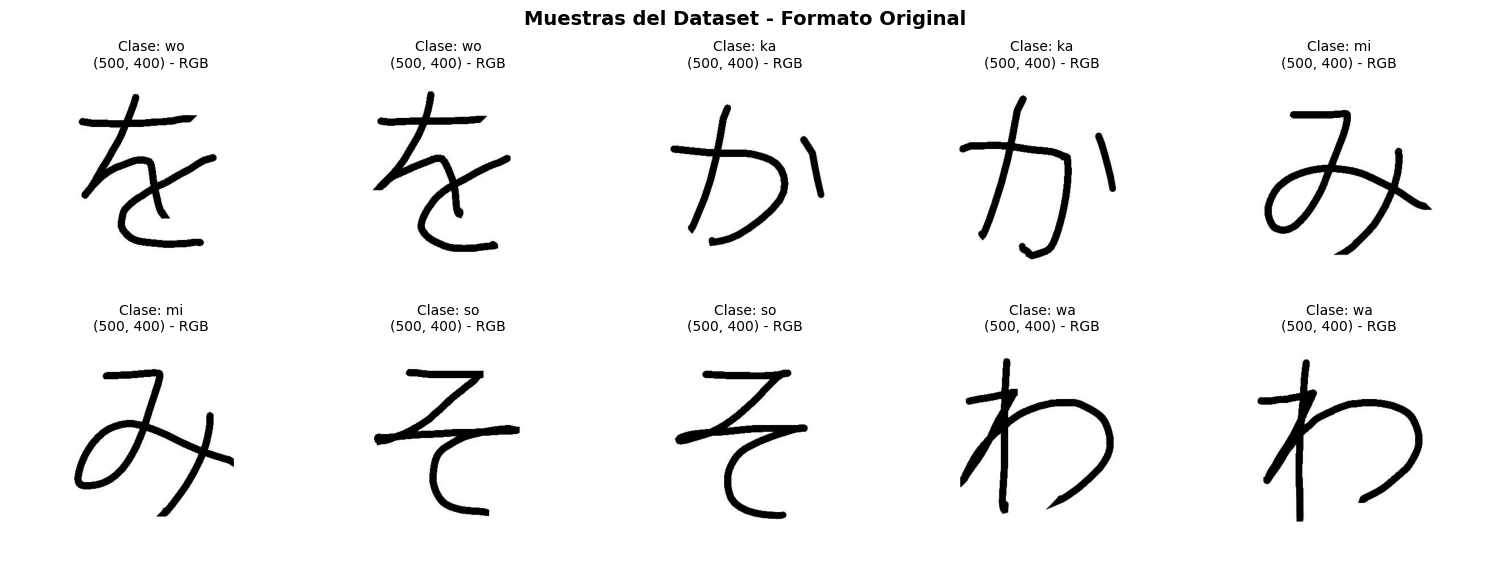

In [8]:
# Analizar propiedades de varias imágenes
import matplotlib.pyplot as plt

def analyze_image_properties(base_path, num_samples=10):
    """
    Analiza las propiedades de imágenes del dataset
    """
    print("Análisis de propiedades de imágenes:")
    print("\n")

    # Tomar muestras de diferentes clases
    train_path = os.path.join(base_path, 'train')
    classes = os.listdir(train_path)[:5]  # Primeras 5 clases

    sizes = []
    modes = []
    sample_images = []

    for cls in classes:
        class_path = os.path.join(train_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith('.jpg')][:2]

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            sizes.append(img.size)
            modes.append(img.mode)
            sample_images.append((img, cls))

    # Estadísticas
    unique_sizes = set(sizes)
    unique_modes = set(modes)

    print(f"Dimensiones encontradas: {unique_sizes}")
    print(f"Modos de color: {unique_modes}")
    print(f"Total analizado: {len(sizes)} imágenes")

    return sample_images

# Analizar imágenes
samples = analyze_image_properties(base_output_path)

# Visualizar muestras
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, (img, cls) in enumerate(samples):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'Clase: {cls}\n{img.size} - {img.mode}', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Muestras del Dataset - Formato Original', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Pre-procesamiento

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

print("Configuración entorno")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")


Configuración entorno
TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:

# CONFIGURACIÓN DE HIPERPARÁMETROS
print("\nDefinición de hiperparámetros")
print("\n")

# Dimensiones de la imagen
IMG_HEIGHT = 64  # Altura a la que redimensionaremos
IMG_WIDTH = 64   # Ancho a la que redimensionaremos
IMG_CHANNELS = 1 # 1 = escala de grises

# Parámetros de entrenamiento
BATCH_SIZE = 32      # Cuántas imágenes procesa a la vez
EPOCHS = 20          # Cuántas veces pasa por todo el dataset
LEARNING_RATE = 0.001 # Qué tan grande son los pasos del optimizador

# Clases
NUM_CLASSES = 46     # Los 46 caracteres hiragana

print(f" Tamaño de imagen: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f" Batch size: {BATCH_SIZE}")
print(f" Epochs: {EPOCHS}")
print(f" Learning rate: {LEARNING_RATE}")
print(f" Número de clases: {NUM_CLASSES}")


Definición de hiperparámetros


 Tamaño de imagen: 64x64x1
 Batch size: 32
 Epochs: 20
 Learning rate: 0.001
 Número de clases: 46


In [11]:

# PREPARACIÓN DE LOS DATOS
print("\nPreparación de generadores de datos")

# ImageDataGenerator: clase que carga y preprocesa imágenes automáticamente
# Explicación del preprocesamiento:
# 1. rescale=1./255: Divide cada píxel por 255 (convierte de 0-255 a 0-1)

# Generador para ENTRENAMIENTO
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización: convierte valores de 0-255 a 0-1
)

# Generador para VALIDACIÓN
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Generador para TEST
test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("Generadores creados (solo con normalización)")


Preparación de generadores de datos
Generadores creados (solo con normalización)


In [12]:
# carga de imagenes desde las carpetas


print("\nCargando imágenes desde carpetas")

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_output_path, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Redimensionar a 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Para 46 clases (one-hot encoding)
    color_mode='grayscale',    # Convertir a escala de grises (1 canal)
    shuffle=True,              # Mezclar las imágenes
    seed=42                    # Para reproducibilidad
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_output_path, 'val'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,  # No mezclar para evaluación consistente
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_output_path, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,  # No mezclar para evaluación consistente
    seed=42
)

print(f"\n Train: {train_generator.samples} imágenes, {len(train_generator)} batches")
print(f" Validation: {val_generator.samples} imágenes, {len(val_generator)} batches")
print(f" Test: {test_generator.samples} imágenes, {len(test_generator)} batches")

# Guardar el mapeo de clases para usar después
class_indices = train_generator.class_indices
print(f"\n Clases detectadas: {len(class_indices)}")
print(f"Primeras 5 clases: {list(class_indices.keys())[:5]}")


Cargando imágenes desde carpetas
Found 3220 images belonging to 46 classes.
Found 690 images belonging to 46 classes.
Found 690 images belonging to 46 classes.

 Train: 3220 imágenes, 101 batches
 Validation: 690 imágenes, 22 batches
 Test: 690 imágenes, 22 batches

 Clases detectadas: 46
Primeras 5 clases: ['aa', 'chi', 'ee', 'fu', 'ha']



Visualización de muestras preprocesadas


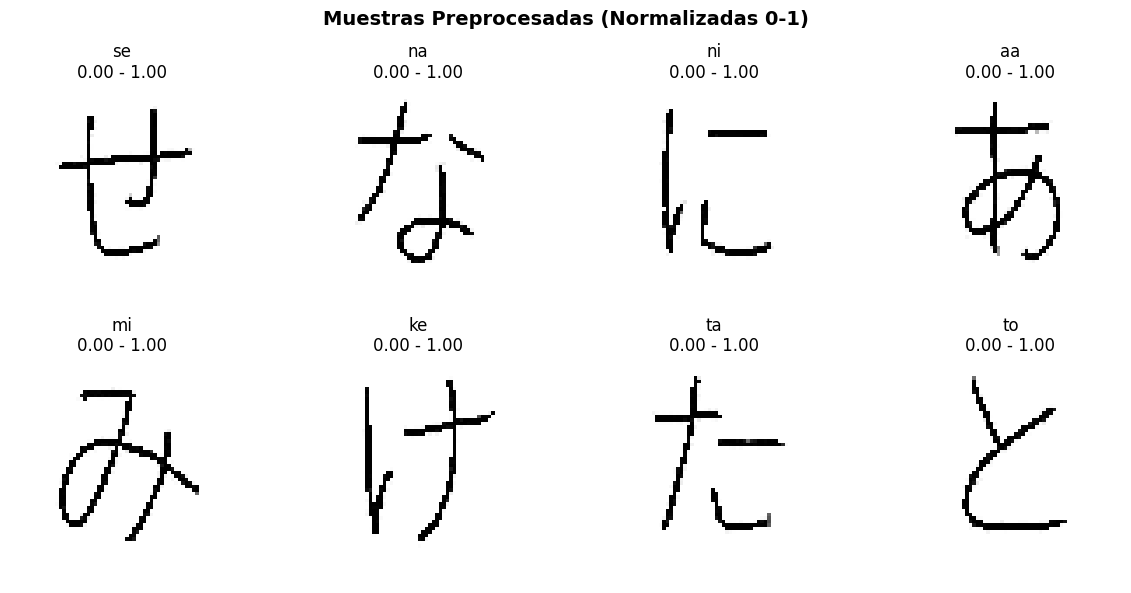


Shape de cada imagen: (64, 64, 1)
Shape de las etiquetas: (46,)
Rango de valores: [0.000, 1.000]


In [15]:

# VISUALIZAR UN BATCH PARA VERIFICAR
print("\nVisualización de muestras preprocesadas")


# Obtener un batch de imágenes
sample_batch, sample_labels = next(train_generator)

# Visualizar algunas imágenes
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Crear diccionario invertido para obtener nombres de clases
idx_to_class = {v: k for k, v in class_indices.items()}

for i in range(8):
    # sample_batch[i] tiene shape (64, 64, 1)
    img = sample_batch[i].squeeze()

    # sample_labels[i] es one-hot, obtener el índice de la clase
    class_idx = np.argmax(sample_labels[i])
    class_name = idx_to_class[class_idx]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{class_name}\n{img.min():.2f} - {img.max():.2f}')
    axes[i].axis('off')

plt.suptitle('Muestras Preprocesadas (Normalizadas 0-1)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nShape de cada imagen: {sample_batch[0].shape}")
print(f"Shape de las etiquetas: {sample_labels[0].shape}")
print(f"Rango de valores: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")

# Creación de arquitectura de la CNN

In [16]:
model = models.Sequential(name='Hiragana_CNN')

# Conv2D: Detecta características básicas (bordes, líneas)
# - 32 filtros: aprenderá 32 patrones diferentes
# - (3,3): tamaño del filtro (ventana que recorre la imagen)
# - activation='relu': función de activación (introduce no-linealidad)
# - input_shape: forma de entrada (64x64x1)

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                        name='conv1'))
print("Capa Conv2D_1: 32 filtros (3x3) - Detecta bordes y líneas básicas")

# MaxPooling2D: Reduce el tamaño de la imagen a la mitad
# - (2,2): toma el valor máximo de cada región 2x2
# - Reduce dimensiones y hace el modelo más robusto
model.add(layers.MaxPooling2D((2, 2), name='pool1'))
print("Capa MaxPool_1: (2x2) - Reduce de 64x64 a 32x32")

# Segunda capa convolucional + Pooling
# Más filtros (64) para detectar características más complejas
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2'))
print("Capa Conv2D_2: 64 filtros (3x3) - Detecta formas más complejas")

model.add(layers.MaxPooling2D((2, 2), name='pool2'))
print("Capa MaxPool_2: (2x2) - Reduce de 32x32 a 16x16")

# Tercera capa convolucional + Pooling
# Aún más filtros (128) para patrones muy específicos
model.add(layers.Conv2D(128, (3, 3), activation='relu', name='conv3'))
print("Capa Conv2D_3: 128 filtros (3x3) - Detecta patrones específicos de caracteres")

model.add(layers.MaxPooling2D((2, 2), name='pool3'))
print("Capa MaxPool_3: (2x2) - Reduce de 16x16 a 8x8")

# Aplanar y capas densas (Fully Connected)
# Flatten: Convierte la matriz 3D en un vector 1D
# Esto es necesario para conectar con las capas densas
model.add(layers.Flatten(name='flatten'))
print("Capa Flatten: Convierte matriz 3D en vector 1D")

# Dense: Capa totalmente conectada
# - 256 neuronas: aprende combinaciones de las características detectadas
# - Dropout: Apaga aleatoriamente 50% de neuronas durante entrenamiento
#   Esto previene overfitting (memorización)
model.add(layers.Dense(256, activation='relu', name='dense1'))
print("Capa Dense_1: 256 neuronas - Aprende combinaciones de características")

model.add(layers.Dropout(0.5, name='dropout1'))
print("Capa Dropout: 50% - Previene overfitting")

# CAPA DE SALIDA
# Dense final: Una neurona por cada clase (46)
# - activation='softmax': Convierte salidas en probabilidades que suman 1
# - Cada neurona representa la probabilidad de una clase
model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='output'))
print("Capa Output: 46 neuronas (softmax) - Una por cada carácter hiragana")



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Capa Conv2D_1: 32 filtros (3x3) - Detecta bordes y líneas básicas
Capa MaxPool_1: (2x2) - Reduce de 64x64 a 32x32
Capa Conv2D_2: 64 filtros (3x3) - Detecta formas más complejas
Capa MaxPool_2: (2x2) - Reduce de 32x32 a 16x16
Capa Conv2D_3: 128 filtros (3x3) - Detecta patrones específicos de caracteres
Capa MaxPool_3: (2x2) - Reduce de 16x16 a 8x8
Capa Flatten: Convierte matriz 3D en vector 1D
Capa Dense_1: 256 neuronas - Aprende combinaciones de características
Capa Dropout: 50% - Previene overfitting
Capa Output: 46 neuronas (softmax) - Una por cada carácter hiragana


In [19]:
model.summary()

total_params = model.count_params()

print(f"\nTotal de parametros {total_params}")

Model: "Hiragana_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 46)             │        11,822 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,398 (4.90 MB)

 Trainable params: 1,284,398 (4.90 MB)

 Non-trainable params: 0 (0.00 B)


Total de parametros 1284398


In [22]:
#compilar modelo
print("\nCompilación del modelo")

# Compilar: Configurar cómo el modelo aprenderá
model.compile(
    # Optimizador: Algoritmo que ajusta los pesos
    # Adam: Adaptativo, funciona bien en la mayoría de casos
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),

    # Función de pérdida: Qué tan "equivocado" está el modelo
    # categorical_crossentropy: Para clasificación multiclase
    loss='categorical_crossentropy',

    # Métricas: Qué mostrar durante el entrenamiento
    # accuracy: % de predicciones correctas
    metrics=['accuracy']
)

print("Optimizador: Adam")
print(f"Learning rate: {LEARNING_RATE}")
print("Función de pérdida: Categorical Crossentropy")
print("Métrica: Accuracy")


Compilación del modelo
Optimizador: Adam
Learning rate: 0.001
Función de pérdida: Categorical Crossentropy
Métrica: Accuracy


In [24]:

# CONFIGURAR CALLBACKS (Herramientas de monitoreo durante entrenamiento)
print("\nConfiguración de callbacks")

# Callbacks: Funciones que se ejecutan durante el entrenamiento

# ModelCheckpoint: Guarda el mejor modelo automáticamente
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='/content/best_hiragana_model.h5',  # Dónde guardar
    monitor='val_accuracy',      # Qué métrica observar
    save_best_only=True,         # Solo guardar si mejora
    mode='max',                  # MAXIMIZAR accuracy
    verbose=1                    # Mostrar mensajes
)

# 2EarlyStopping: Detiene el entrenamiento si no mejora
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',      # Qué métrica observar
    patience=5,                  # Esperar 5 epochs sin mejora
    restore_best_weights=True,   # Restaurar los mejores pesos
    verbose=1
)

# ReduceLROnPlateau: Reduce el learning rate si no mejora
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                  # Reducir LR a la mitad
    patience=3,                  # Esperar 3 epochs
    min_lr=1e-7,                 # LR mínimo
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]


Configuración de callbacks


# Entrenamiento

In [25]:

#ENTRENAR EL MODELO
print("\Iniciando entrenamiento")
print(f"Epochs máximos: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Datos de entrenamiento: {train_generator.samples} imágenes")
print(f"Datos de validación: {val_generator.samples} imágenes")

# fit: Entrenar el modelo
history = model.fit(
    train_generator,              # Datos de entrenamiento
    epochs=EPOCHS,                # Número máximo de epochs
    validation_data=val_generator, # Datos de validación
    callbacks=callbacks_list,     # Callbacks configurados
    verbose=1                     # Mostrar progreso detallado
)

print("Entrenao")

\Iniciando entrenamiento
Epochs máximos: 20
Batch size: 32
Datos de entrenamiento: 3220 imágenes
Datos de validación: 690 imágenes
Epoch 1/20


<>:2: SyntaxWarning: invalid escape sequence '\I'
<>:2: SyntaxWarning: invalid escape sequence '\I'
/tmp/ipython-input-4202367197.py:2: SyntaxWarning: invalid escape sequence '\I'
  print("\Iniciando entrenamiento")
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1103 - loss: 3.5223
Epoch 1: val_accuracy improved from -inf to 0.99420, saving model to /content/best_hiragana_model.h5


101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.1125 - loss: 3.5130 - val_accuracy: 0.9942 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 2/20
100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9271 - loss: 0.2191
Epoch 2: val_accuracy improved from 0.99420 to 1.00000, saving model to /content/best_hiragana_model.h5


101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9275 - loss: 0.2177 - val_accuracy: 1.0000 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9782 - loss: 0.0600
Epoch 3: val_accuracy did not improve from 1.00000
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9783 - loss: 0.0600 - val_accuracy: 1.0000 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9873 - loss: 0.0366
Epoch 4: val_accuracy did not improve from 1.00000
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9874 - loss: 0.0366 - val_accuracy: 1.0000 - val_loss: 4.9876e-04 - learning_rate: 0.0010
Epoch 5/20
100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9909 - loss: 0.0315
Epoch 5: val_accuracy did not improve from 1.00000
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9909 - loss: 0.0314 - val_accuracy: 1.0000 - val_loss: 8.4830e-05 - learning_rate: 0.0010
Epoch 6/20


Visualización de curvas de aprendizaje


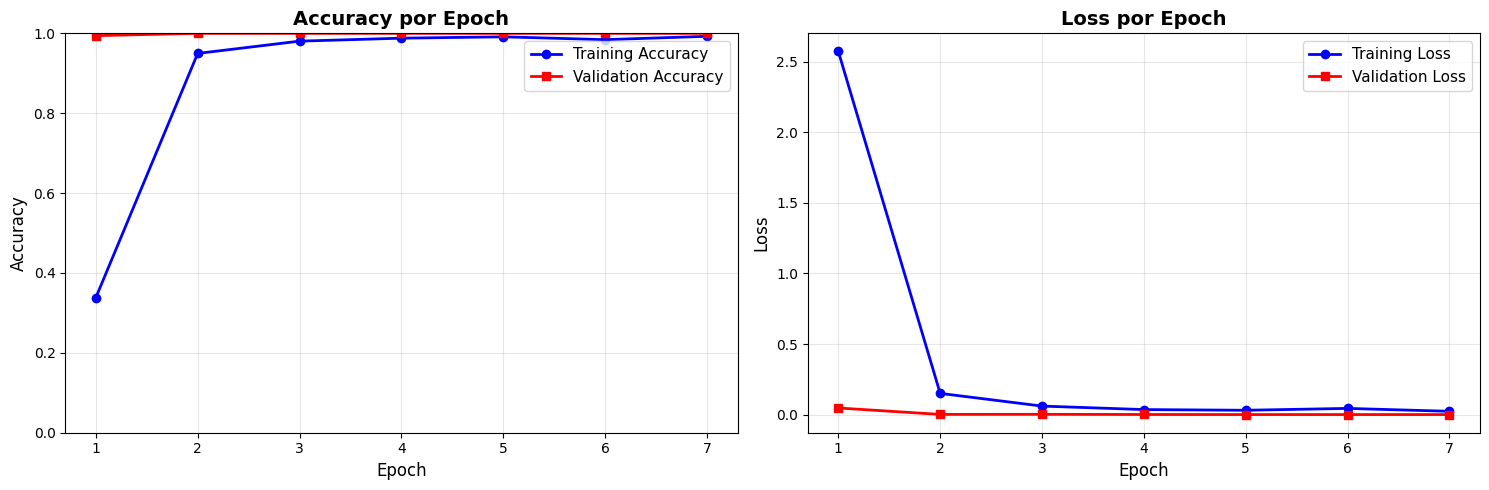


Resultados del entrenamiento:
Epochs completados: 7

Mejor validation accuracy: 1.0000 (Epoch 2)
Training accuracy final: 0.9925
Validation accuracy final: 1.0000

Mejor validation loss: 0.0000 (Epoch 7)
Training loss final: 0.0231
Validation loss final: 0.0000

Gap entre train y validation: -0.0075
Buen balance entre train y validation


In [26]:
#VISUALIZAR CURVAS DE APRENDIZAJE
print("\nVisualización de curvas de aprendizaje")

# history.history contiene todas las métricas por epoch
# Extraer datos
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = range(1, len(train_loss) + 1)

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Accuracy
axes[0].plot(epochs_range, train_accuracy, 'b-o', label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, val_accuracy, 'r-s', label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy por Epoch', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Gráfico 2: Loss
axes[1].plot(epochs_range, train_loss, 'b-o', label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, val_loss, 'r-s', label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss por Epoch', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Imprimir estadísticas finales
print("\nResultados del entrenamiento:")
print(f"Epochs completados: {len(train_loss)}")
print(f"\nMejor validation accuracy: {max(val_accuracy):.4f} (Epoch {val_accuracy.index(max(val_accuracy)) + 1})")
print(f"Training accuracy final: {train_accuracy[-1]:.4f}")
print(f"Validation accuracy final: {val_accuracy[-1]:.4f}")
print(f"\nMejor validation loss: {min(val_loss):.4f} (Epoch {val_loss.index(min(val_loss)) + 1})")
print(f"Training loss final: {train_loss[-1]:.4f}")
print(f"Validation loss final: {val_loss[-1]:.4f}")

# Análisis de overfitting
gap = train_accuracy[-1] - val_accuracy[-1]
print(f"\nGap entre train y validation: {gap:.4f}")
if gap > 0.1:
    print("Posible overfitting detectado (gap > 0.1)")
    print("   Considera: agregar más dropout, data augmentation, o regularización")
elif gap < 0.05:
    print("Buen balance entre train y validation")
else:
    print("Gap aceptable")

In [28]:
# EVALUACIÓN EN EL TEST SET
print("\nEvaluación en el conjunto de Test")

# Evaluar en el test set
print("Evaluando en test set...\n")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\n")
print("RESULTADOS FINALES:")
print(f"Training Accuracy:   {train_accuracy[-1]:.4f} ({train_accuracy[-1]*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy[-1]:.4f} ({val_accuracy[-1]*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n")
print(f"Training Loss:       {train_loss[-1]:.4f}")
print(f"Validation Loss:     {val_loss[-1]:.4f}")
print(f"Test Loss:           {test_loss:.4f}")

# Análisis de generalización
if test_accuracy >= 0.95:
    print("\nEXCELENTE: El modelo generaliza muy bien (>95%)")
elif test_accuracy >= 0.90:
    print("\nBUENO: El modelo generaliza bien (90-95%)")
elif test_accuracy >= 0.85:
    print("\n  ACEPTABLE: El modelo generaliza razonablemente (85-90%)")
else:
    print("\n  ATENCIÓN: Posible overfitting (test accuracy < 85%)")

gap_test = val_accuracy[-1] - test_accuracy
print(f"\nDiferencia val-test: {gap_test:.4f}")
if abs(gap_test) < 0.05:
    print(" Generalización consistente entre validación y test")


Evaluación en el conjunto de Test
Evaluando en test set...

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 0.0010


RESULTADOS FINALES:
Training Accuracy:   0.9925 (99.25%)
Validation Accuracy: 1.0000 (100.00%)
Test Accuracy:       1.0000 (100.00%)


Training Loss:       0.0231
Validation Loss:     0.0000
Test Loss:           0.0008

EXCELENTE: El modelo generaliza muy bien (>95%)

Diferencia val-test: 0.0000
 Generalización consistente entre validación y test


In [32]:

#GENERAR PREDICCIONES PARA MATRIZ DE CONFUSIÓN
print("\nGenerando predicciones para análisis detallado")

# Resetear el generador para empezar desde el inicio
test_generator.reset()

# Obtener predicciones
print("Generando predicciones en test set...")
predictions = model.predict(test_generator, verbose=1)

# predictions tiene shape (690, 46) - probabilidades para cada clase
# Obtener la clase con mayor probabilidad
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener los nombres de las clases
class_labels = list(test_generator.class_indices.keys())

print(f"\nPredicciones generadas: {len(predicted_classes)}")
print(f"Clases únicas: {len(class_labels)}")


Generando predicciones para análisis detallado
Generando predicciones en test set...
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

Predicciones generadas: 690
Clases únicas: 46



Matriz de Confusión
Matriz de confusión generada: (46, 46)
Total de predicciones: 690
Predicciones correctas: 690
Predicciones incorrectas: 0


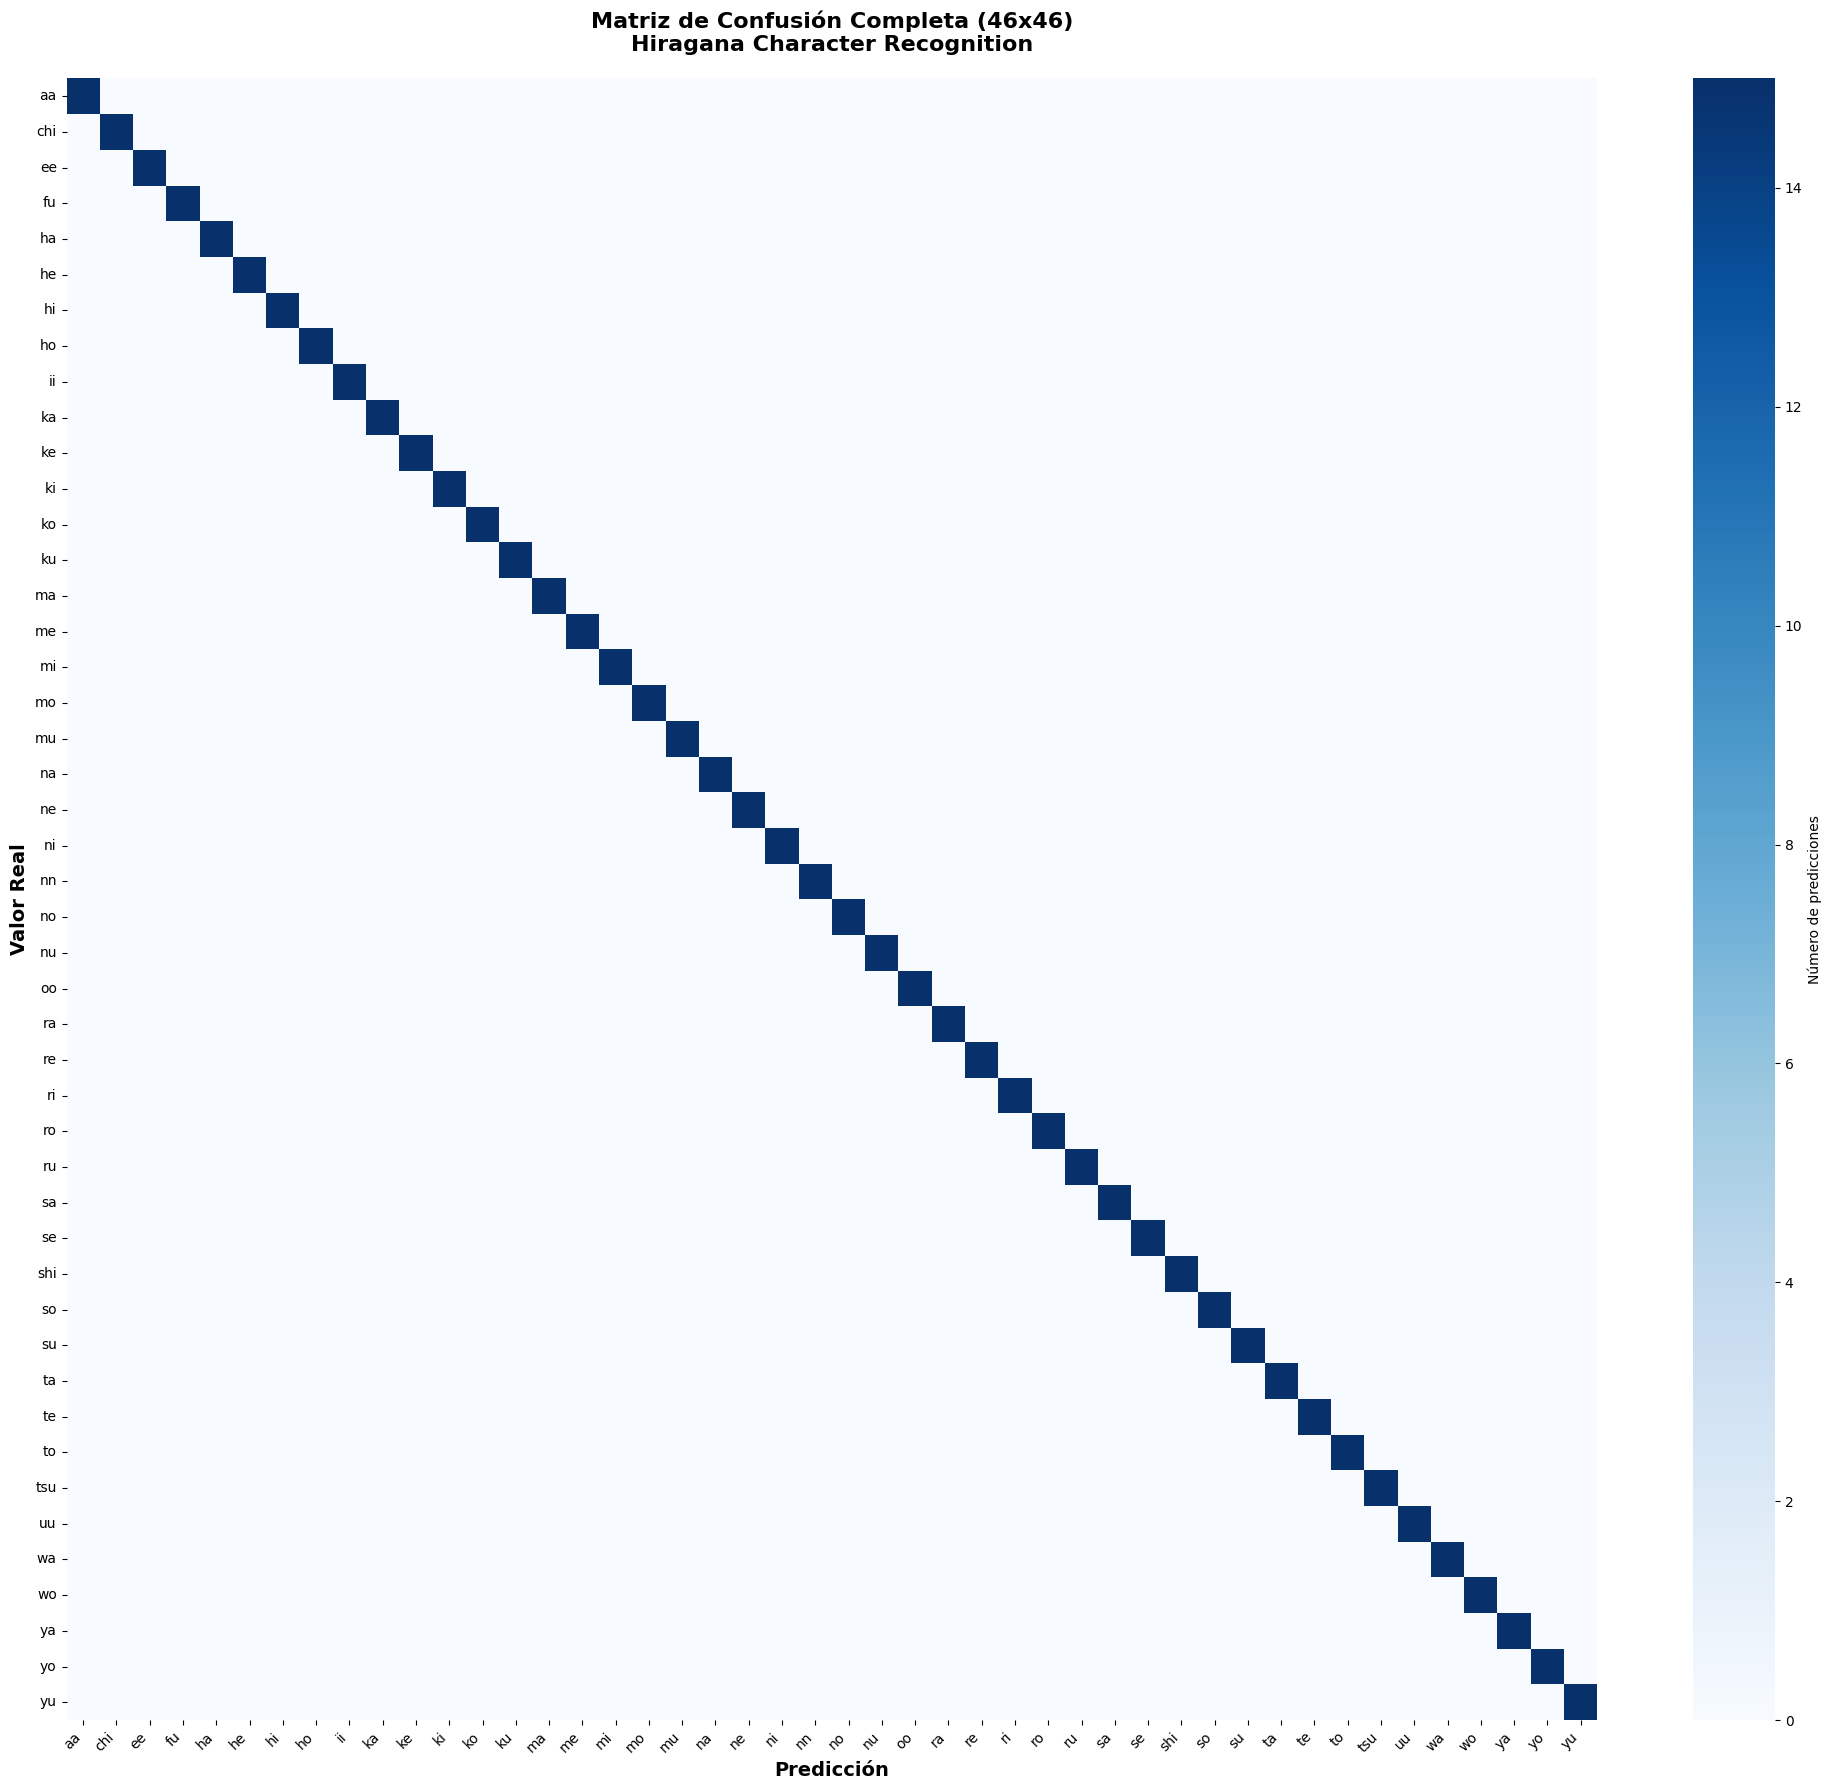


En la matriz de confusión:
  - Diagonal = predicciones correctas
  - Fuera de diagonal = confusiones entre clases


In [38]:
#  MATRIZ DE CONFUSIÓN 46x46
print("\nMatriz de Confusión")

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Calcular matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

print(f"Matriz de confusión generada: {cm.shape}")
print(f"Total de predicciones: {cm.sum()}")
print(f"Predicciones correctas: {np.trace(cm)}")
print(f"Predicciones incorrectas: {cm.sum() - np.trace(cm)}")

# Visualizar matriz de confusión completa (46x46)
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Número de predicciones'})
plt.xlabel('Predicción', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real', fontsize=14, fontweight='bold')
plt.title('Matriz de Confusión Completa (46x46)\nHiragana Character Recognition',
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nEn la matriz de confusión:")
print("  - Diagonal = predicciones correctas")
print("  - Fuera de diagonal = confusiones entre clases")


PRUEBA CON IMAGEN PERSONALIZADA
Imagen encontrada: /content/ni_test.jpeg
Dimensiones originales: (1600, 1401)
Modo: RGB
 Shape final para predicción: (1, 64, 64, 1)
 Rango de valores: [0.035, 0.486]


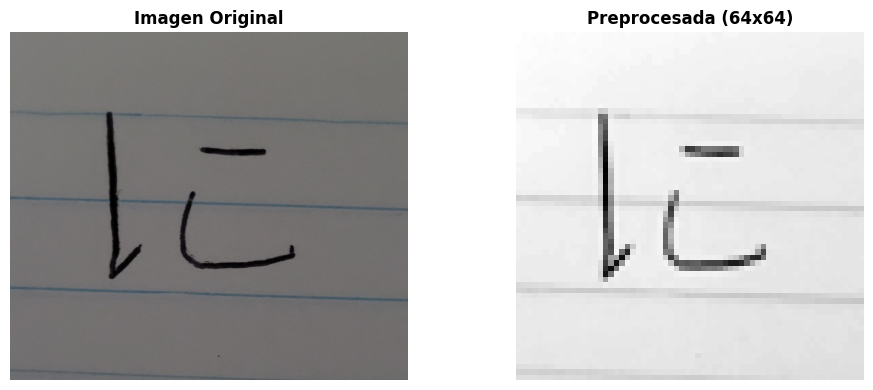

In [39]:
# PRUEBA CON IMAGEN PERSONALIZADA
print("\nPRUEBA CON IMAGEN PERSONALIZADA")

from PIL import Image
import numpy as np

# Ruta de tu imagen
image_path = "/content/ni_test.jpeg"

# Verificar que existe
if os.path.exists(image_path):
    print(f"Imagen encontrada: {image_path}")

    # Cargar la imagen
    img_original = Image.open(image_path)
    print(f"Dimensiones originales: {img_original.size}")
    print(f"Modo: {img_original.mode}")

    # Preprocesar la imagen (igual que en entrenamiento)
    # 1. Convertir a escala de grises
    img_gray = img_original.convert('L')

    # 2. Redimensionar a 64x64
    img_resized = img_gray.resize((IMG_WIDTH, IMG_HEIGHT))

    # 3. Convertir a array numpy
    img_array = np.array(img_resized)

    # 4. Normalizar (dividir por 255)
    img_normalized = img_array / 255.0

    # 5. Añadir dimensiones necesarias: (64, 64) → (1, 64, 64, 1)
    #    batch_size=1, height=64, width=64, channels=1
    img_input = img_normalized.reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

    print(f" Shape final para predicción: {img_input.shape}")
    print(f" Rango de valores: [{img_input.min():.3f}, {img_input.max():.3f}]")

    # Visualizar la imagen preprocesada
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].imshow(img_original, cmap='gray')
    axes[0].set_title('Imagen Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(img_resized, cmap='gray')
    axes[1].set_title(f'Preprocesada ({IMG_WIDTH}x{IMG_HEIGHT})', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print(f" Error: No se encontró la imagen en {image_path}")
    print("   Asegúrate de subirla a Colab primero")

In [37]:
# HACER PREDICCIÓN
print("\nREALIZANDO PREDICCIÓN")

# Hacer predicción
prediction = model.predict(img_input, verbose=0)

# prediction tiene shape (1, 46) - probabilidades para cada clase
# Obtener la clase con mayor probabilidad
predicted_class_idx = np.argmax(prediction[0])
predicted_class_name = class_labels[predicted_class_idx]
confidence = prediction[0][predicted_class_idx] * 100

print(f"\nRESULTADO:")
print(f"Carácter predicho: {predicted_class_name}")
print(f"Confianza: {confidence:.2f}%")

# Mostrar top 5 predicciones
top_n = 10
print(f"\nTop {top_n} predicciones:")
top10_indices = np.argsort(prediction[0])[-top_n:][::-1]
for i, idx in enumerate(top10_indices, 1):
    class_name = class_labels[idx]
    prob = prediction[0][idx] * 100
    bar = "█" * int(prob/2)
    print(f"{i}. {class_name:5s} : {prob:6.2f}% {bar}")


REALIZANDO PREDICCIÓN

RESULTADO:
Carácter predicho: yu
Confianza: 11.89%

Top 10 predicciones:
1. yu    :  11.89% █████
2. ha    :  11.87% █████
3. nu    :  10.60% █████
4. ho    :  10.40% █████
5. ni    :   8.13% ████
6. me    :   5.08% ██
7. no    :   4.91% ██
8. ka    :   2.99% █
9. se    :   2.74% █
10. mi    :   2.50% █


In [45]:
# predictor de hiragana

def test_image(image_path, top_n=5, visualize=True):
    """
    Predice el carácter Hiragana de una imagen

    Parámetros:
    -----------
    image_path : str
        Ruta a la imagen a predecir
    top_n : int, default=5
        Número de clases más probables a mostrar
    visualize : bool, default=True
        Si True, muestra visualización de la imagen y resultados

    Retorna:
    --------
    dict con:
        - 'predicted_class': Clase predicha
        - 'confidence': Confianza de la predicción (%)
        - 'top_predictions': Lista de tuplas (clase, probabilidad)
    """

    # Verificar que la imagen existe
    if not os.path.exists(image_path):
        print(f"Error: No se encontró la imagen en {image_path}")
        return None

    print(f"\nAnalizando: {os.path.basename(image_path)}")


    # 1. Cargar imagen original
    img_original = Image.open(image_path)
    print(f"Dimensiones originales: {img_original.size}")
    print(f"Modo: {img_original.mode}")

    # 2. Preprocesar
    img_gray = img_original.convert('L')
    img_resized = img_gray.resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img_resized)
    img_normalized = img_array / 255.0
    img_input = img_normalized.reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

    print(f"Preprocesada a: {IMG_WIDTH}x{IMG_HEIGHT}")
    print(f"Rango normalizado: [{img_input.min():.3f}, {img_input.max():.3f}]")

    # 3. Hacer predicción
    prediction = model.predict(img_input, verbose=0)

    # 4. Extraer resultados
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class_name = class_labels[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx] * 100

    # 5. Top N predicciones
    top_indices = np.argsort(prediction[0])[-top_n:][::-1]
    top_predictions = [(class_labels[idx], prediction[0][idx] * 100)
                       for idx in top_indices]

    # 6. Mostrar resultados
    print(f"PREDICCIÓN: {predicted_class_name}")
    print(f"CONFIANZA: {confidence:.2f}%")


    print(f"\nTop {top_n} predicciones:")
    for i, (class_name, prob) in enumerate(top_predictions, 1):
        bar = "█" * int(prob/2)
        print(f"{i:2d}. {class_name:5s} : {prob:6.2f}% {bar}")

    # 7. Visualización (opcional)
    if visualize:
        fig = plt.figure(figsize=(14, 5))

        # Subplot 1: Imagen original
        ax1 = plt.subplot(1, 3, 1)
        ax1.imshow(img_original, cmap='gray')
        ax1.set_title('Imagen Original', fontsize=12, fontweight='bold')
        ax1.axis('off')

        # Subplot 2: Imagen preprocesada
        ax2 = plt.subplot(1, 3, 2)
        ax2.imshow(img_resized, cmap='gray')
        ax2.set_title(f'Preprocesada\n({IMG_WIDTH}x{IMG_HEIGHT})',
                     fontsize=12, fontweight='bold')
        ax2.axis('off')

        # Subplot 3: Gráfico de barras con top predicciones
        ax3 = plt.subplot(1, 3, 3)
        classes = [item[0] for item in top_predictions]
        probs = [item[1] for item in top_predictions]

        colors = ['green' if i == 0 else 'steelblue' for i in range(len(classes))]
        bars = ax3.barh(range(len(classes)), probs, color=colors, edgecolor='black')
        ax3.set_yticks(range(len(classes)))
        ax3.set_yticklabels(classes)
        ax3.set_xlabel('Probabilidad (%)', fontsize=11)
        ax3.set_title(f'Top {top_n} Predicciones', fontsize=12, fontweight='bold')
        ax3.invert_yaxis()
        ax3.set_xlim([0, 100])

        # Agregar valores en las barras
        for i, (bar, prob) in enumerate(zip(bars, probs)):
            ax3.text(prob + 2, i, f'{prob:.1f}%',
                    va='center', fontsize=9, fontweight='bold')

        plt.suptitle(f'Predicción: {predicted_class_name} ({confidence:.1f}%)',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    # 8. Retornar resultados
    return {
        'predicted_class': predicted_class_name,
        'confidence': confidence,
        'top_predictions': top_predictions,
        'image_path': image_path
    }

print("\nUso:")
print("   result = test_image('ruta/imagen.jpg', top_n=5)")
print("   result = test_image('ruta/imagen.jpg', top_n=10, visualize=False)")


Uso:
   result = test_image('ruta/imagen.jpg', top_n=5)
   result = test_image('ruta/imagen.jpg', top_n=10, visualize=False)



Analizando: ni_test.jpeg
Dimensiones originales: (1600, 1401)
Modo: RGB
Preprocesada a: 64x64
Rango normalizado: [0.035, 0.486]
PREDICCIÓN: yu
CONFIANZA: 11.89%

Top 10 predicciones:
 1. yu    :  11.89% █████
 2. ha    :  11.87% █████
 3. nu    :  10.60% █████
 4. ho    :  10.40% █████
 5. ni    :   8.13% ████
 6. me    :   5.08% ██
 7. no    :   4.91% ██
 8. ka    :   2.99% █
 9. se    :   2.74% █
10. mi    :   2.50% █


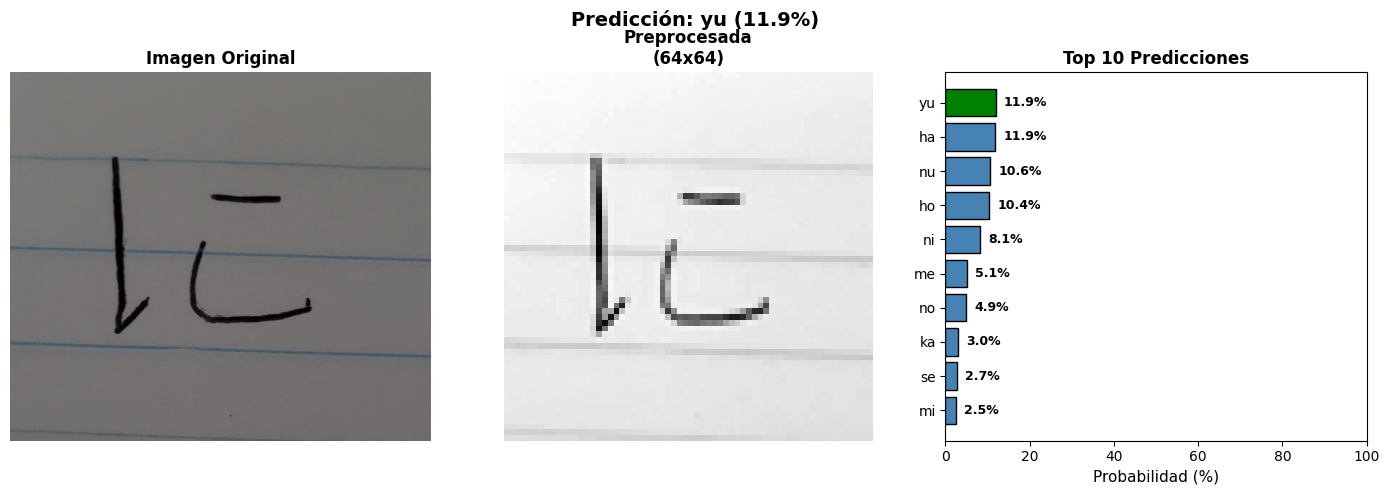

In [48]:
res=test_image('/content/ni_test.jpeg', top_n=10)


Analizando: ni_test2.jpeg
Dimensiones originales: (1346, 1174)
Modo: RGB
Preprocesada a: 64x64
Rango normalizado: [0.000, 0.463]
PREDICCIÓN: ho
CONFIANZA: 15.57%

Top 10 predicciones:
 1. ho    :  15.57% ███████
 2. ta    :  15.30% ███████
 3. nu    :   7.35% ███
 4. ha    :   4.89% ██
 5. wo    :   4.81% ██
 6. re    :   4.43% ██
 7. me    :   4.39% ██
 8. ke    :   3.48% █
 9. se    :   3.47% █
10. na    :   2.95% █


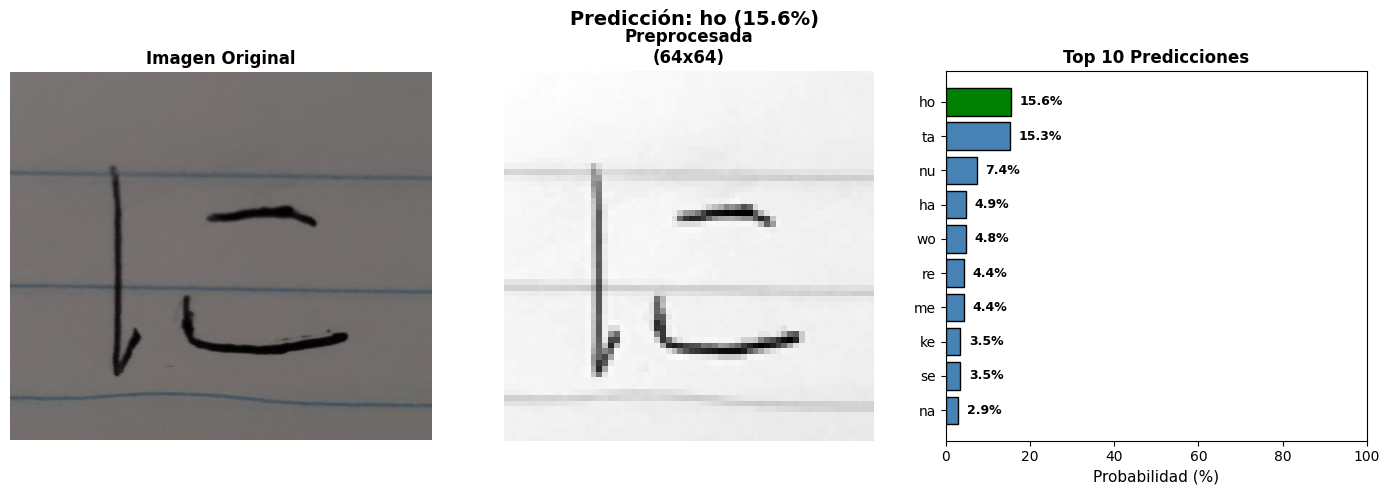

In [51]:
res=test_image('/content/ni_test2.jpeg', top_n=10)


Analizando: ni_test3.jpeg
Dimensiones originales: (775, 684)
Modo: RGB
Preprocesada a: 64x64
Rango normalizado: [0.078, 0.447]
PREDICCIÓN: ha
CONFIANZA: 14.31%

Top 10 predicciones:
 1. ha    :  14.31% ███████
 2. nu    :  11.46% █████
 3. ho    :   9.42% ████
 4. me    :   8.04% ████
 5. ni    :   7.31% ███
 6. yu    :   6.51% ███
 7. na    :   3.47% █
 8. ne    :   3.32% █
 9. ka    :   3.12% █
10. no    :   3.09% █


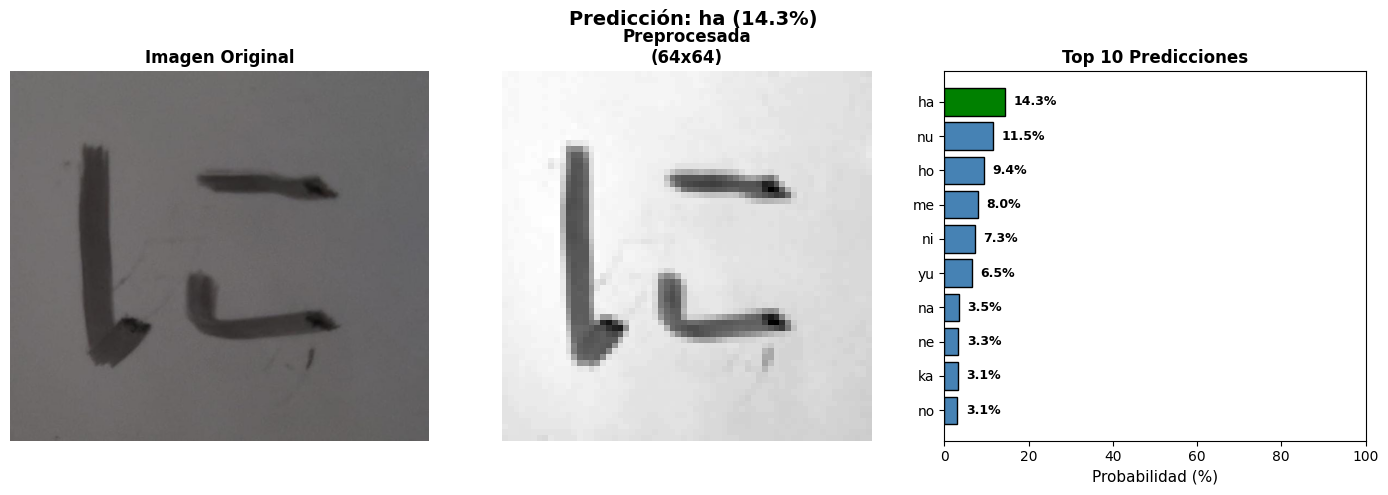

In [52]:
res=test_image('/content/ni_test3.jpeg', top_n=10)


Analizando: ni_test4.jpg
Dimensiones originales: (500, 400)
Modo: RGB
Preprocesada a: 64x64
Rango normalizado: [0.000, 1.000]
PREDICCIÓN: ni
CONFIANZA: 99.90%

Top 10 predicciones:
 1. ni    :  99.90% █████████████████████████████████████████████████
 2. ho    :   0.08% 
 3. ko    :   0.01% 
 4. te    :   0.00% 
 5. yo    :   0.00% 
 6. ha    :   0.00% 
 7. ee    :   0.00% 
 8. nu    :   0.00% 
 9. ku    :   0.00% 
10. yu    :   0.00% 


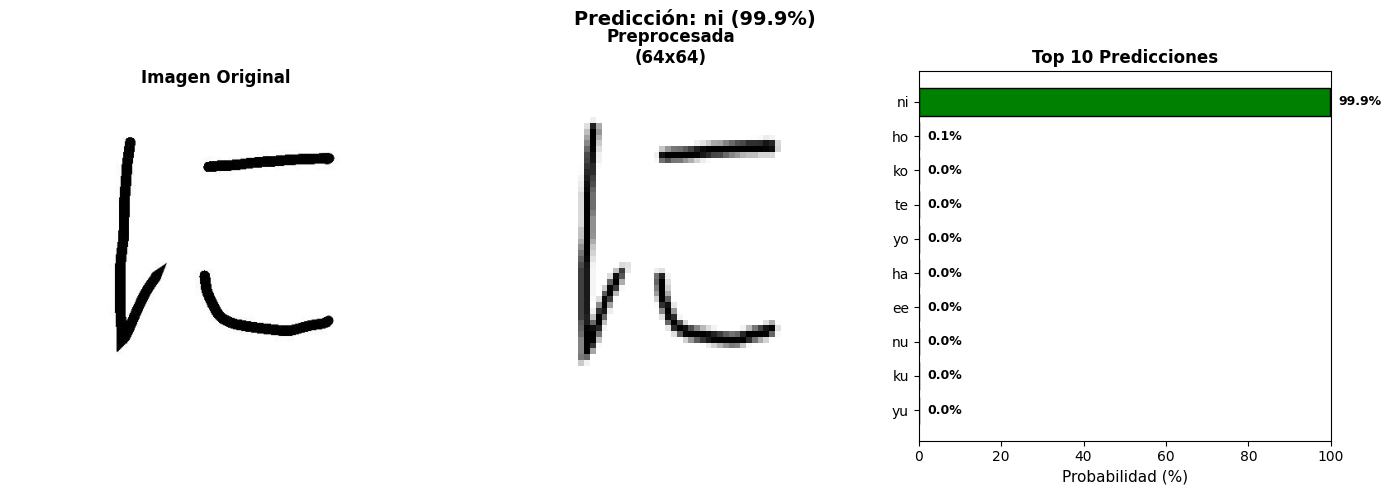

In [54]:
res=test_image('/content/ni_test4.jpg', top_n=10)


Analizando: ni_test5.jpg
Dimensiones originales: (64, 64)
Modo: RGB
Preprocesada a: 64x64
Rango normalizado: [0.000, 1.000]
PREDICCIÓN: yu
CONFIANZA: 78.63%

Top 10 predicciones:
 1. yu    :  78.63% ███████████████████████████████████████
 2. ha    :   6.35% ███
 3. sa    :   3.01% █
 4. se    :   2.09% █
 5. no    :   1.18% 
 6. ki    :   1.10% 
 7. he    :   0.99% 
 8. mi    :   0.73% 
 9. yo    :   0.69% 
10. ka    :   0.69% 


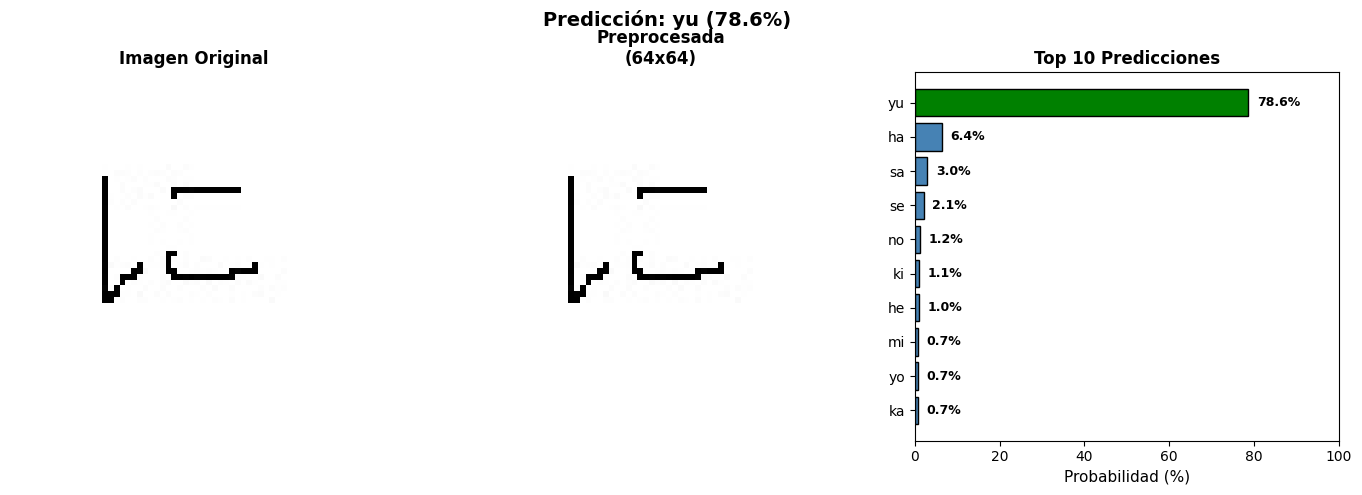

In [58]:
res=test_image('/content/ni_test5.jpg', top_n=10)


Analizando: ni_wiki.png
Dimensiones originales: (225, 225)
Modo: P
Preprocesada a: 64x64
Rango normalizado: [0.000, 1.000]
PREDICCIÓN: ni
CONFIANZA: 68.43%

Top 10 predicciones:
 1. ni    :  68.43% ██████████████████████████████████
 2. ha    :  25.40% ████████████
 3. ta    :   1.63% 
 4. na    :   1.33% 
 5. ke    :   1.15% 
 6. nu    :   0.76% 
 7. re    :   0.58% 
 8. ho    :   0.30% 
 9. te    :   0.18% 
10. ka    :   0.04% 


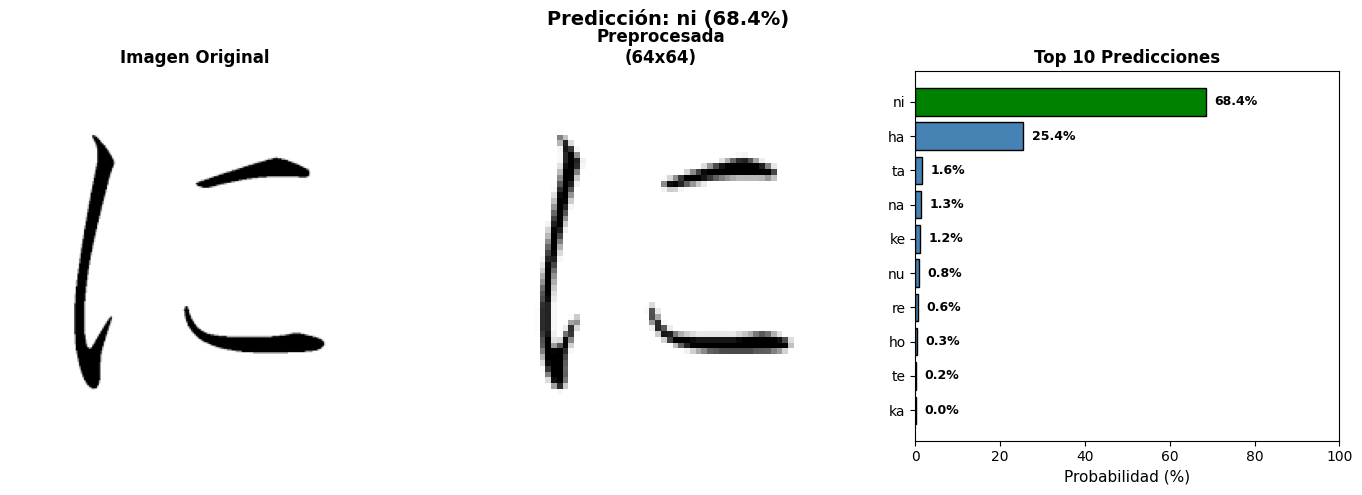

In [59]:
res=test_image('/content/ni_wiki.png', top_n=10)


Analizando: ni_testL.jpeg
Dimensiones originales: (799, 707)
Modo: RGB
Preprocesada a: 64x64
Rango normalizado: [0.157, 0.745]
PREDICCIÓN: ni
CONFIANZA: 13.14%

Top 10 predicciones:
 1. ni    :  13.14% ██████
 2. ha    :  11.61% █████
 3. na    :   8.08% ████
 4. yo    :   6.38% ███
 5. ta    :   5.77% ██
 6. sa    :   5.03% ██
 7. re    :   5.01% ██
 8. ke    :   4.89% ██
 9. ko    :   4.00% █
10. ho    :   3.83% █


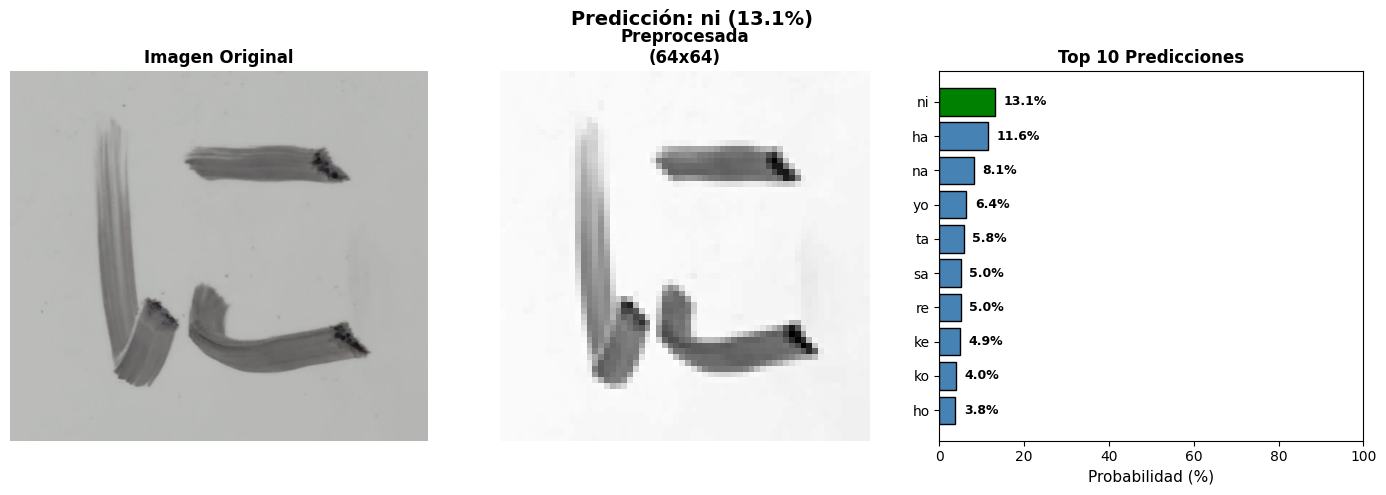

In [61]:
res=test_image('/content/ni_testL.jpeg', top_n=10)